# IMDB movie reviews classification

Importing the necessary libraries:

In [37]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [38]:
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style("darkgrid", {'axes.grid': True})  

In [39]:
data = pd.read_csv('C:/Users/Akshat/Desktop/Akshat/Python Projects/Image Classification/IMDB Dataset.csv')
print(data.head())
print(data.shape)
data.info()

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


Number of positive and negative reviews

In [40]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Now we will encode the labels, 0 for a negative review and 1 for a positive review.

In [41]:
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

A peek into the data:

In [42]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Now we see the average number of words in the sample considered:

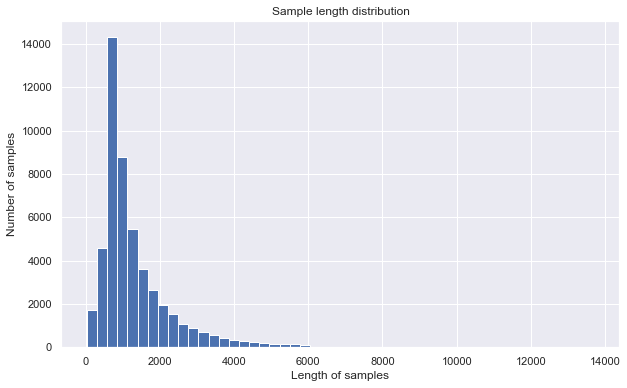

In [43]:
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(data['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

We form a matrix where the rows represent the different reviews, while the columns are the different word tokens:

In [44]:
# Calling the tokenizer function:
vectorizer = CountVectorizer()

# So, we get a structure like:
#        | word1 | word2 | word3 | word4 |
# text1  |   1   |   0   |   1   |   0   |
# text2  |   0   |   2   |   0   |   1   |
# text3  |   1   |   1   |   1   |   0   |
# text4  |   0   |   0   |   0   |   1   |

# Using the tokenizer function on the given data set:
vect_texts = vectorizer.fit_transform(list(data['review']))
# ['word1', 'word2', 'word3', 'word4']
all_ngram = vectorizer.get_feature_names()
num_ngram = min(50, len(all_ngram))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngram, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngram), reverse=True)])
ngrams = all_ngram[:num_ngram]
counts = all_counts[:num_ngram]

idx = np.arange(num_ngram)

The frequency distribution plot of the most seen words in the corpus:

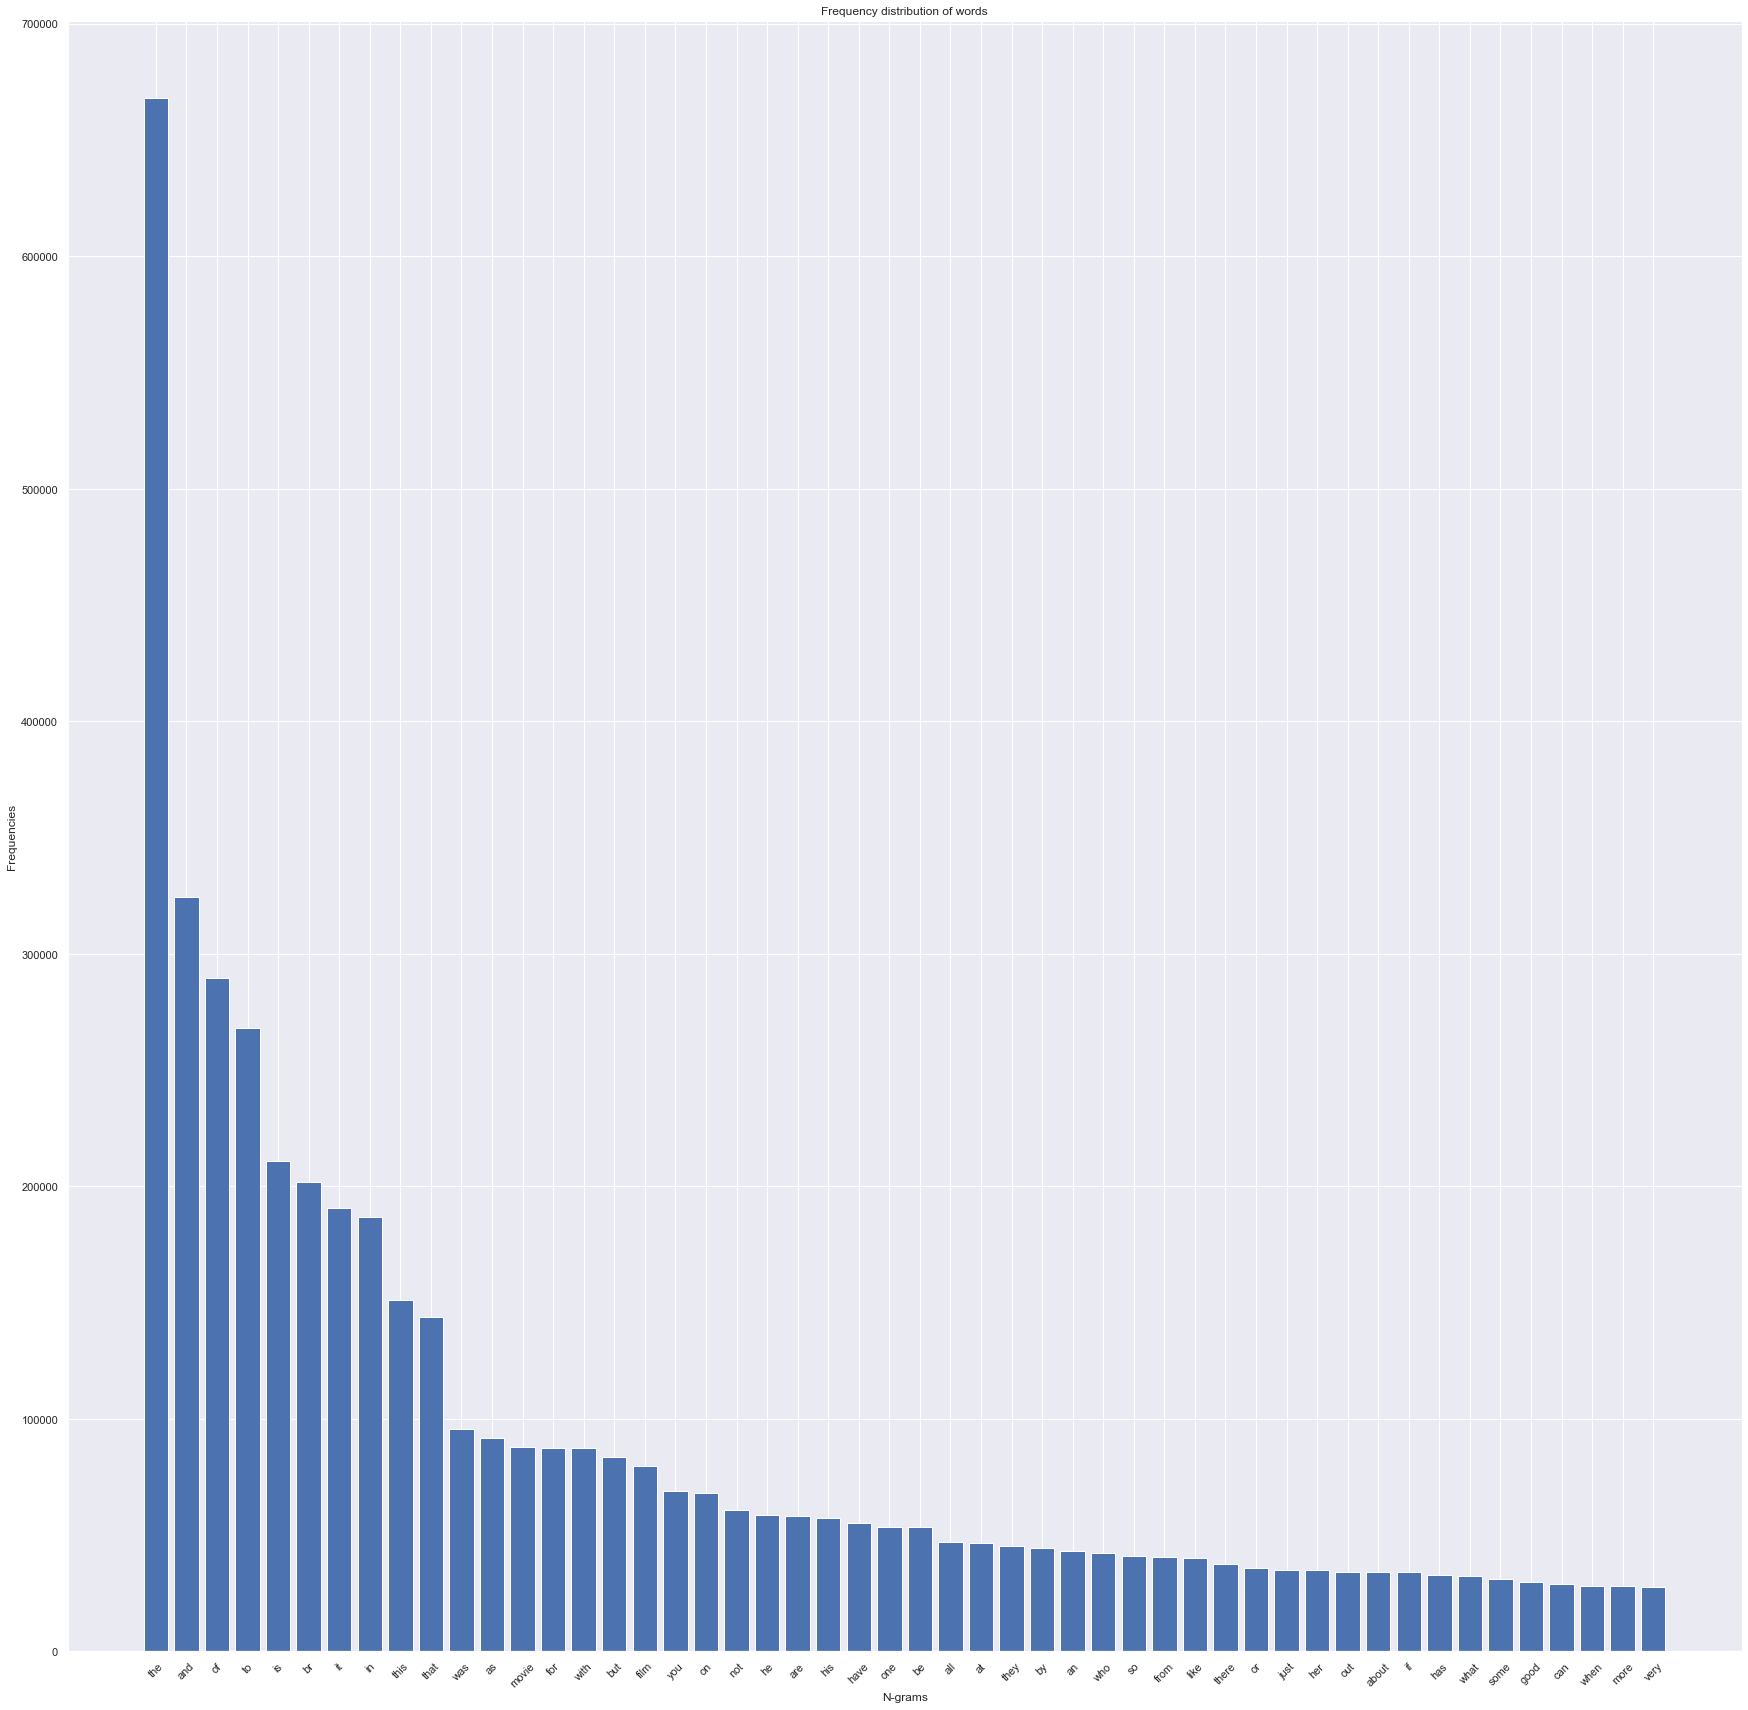

In [45]:
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of words')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [46]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

In [47]:
def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range': NGRAM_RANGE,
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOC_FREQ,
    }
    # Learning vocabulary from training texts and vectorizing training and validation sets:
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts

Vectorizing the data:

In [48]:
vect_data = ngram_vectorize(data['review'], data['sentiment'])
print(vect_data.shape)

(50000, 20000)


In [49]:
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(data['review'])
print(tr_texts.shape)

(50000, 101895)


In [50]:
X = vect_data.toarray()
y = (np.array(data['sentiment']))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


In [52]:
# First, let's create a function that returns the appropriate number of units and the activation for the last layer.
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [53]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
DROPOUT_RATE = 0.2
UNITS = 64
LAYERS = 2
input_shape = X_train.shape[1:]

In [54]:
op_units, op_activation = 1, 'sigmoid'

In [55]:
model = keras.Sequential()
# Applies Dropout to the input
model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS - 1):
    model.add(Dense(units=UNITS, activation='relu'))
    model.add(Dropout(rate=DROPOUT_RATE))

model.add(Dense(units=op_units, activation=op_activation))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 20000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1280064   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [56]:
LEARNING_RATE = 1e-3

# Compile model with parameters
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

EPOCHS = 100
BATCH_SIZE = 128

In [57]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

In [58]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test),
                    verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 12s 311us/sample - loss: 0.4059 - acc: 0.8749 - val_loss: 0.2453 - val_acc: 0.9138
Epoch 2/100
40000/40000 [==============================] - 12s 292us/sample - loss: 0.2081 - acc: 0.9234 - val_loss: 0.1947 - val_acc: 0.9284
Epoch 3/100
40000/40000 [==============================] - 12s 308us/sample - loss: 0.1642 - acc: 0.9392 - val_loss: 0.1831 - val_acc: 0.9308
Epoch 4/100
40000/40000 [==============================] - 13s 314us/sample - loss: 0.1376 - acc: 0.9497 - val_loss: 0.1769 - val_acc: 0.9330
Epoch 5/100
40000/40000 [==============================] - 12s 296us/sample - loss: 0.1167 - acc: 0.9584 - val_loss: 0.1776 - val_acc: 0.9332
Epoch 6/100
40000/40000 [==============================] - 12s 306us/sample - loss: 0.1049 - acc: 0.9627 - val_loss: 0.1788 - val_acc: 0.9330


The plot for training and validation accuracy as well as loss.

In [59]:
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    # Plot accuracy
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

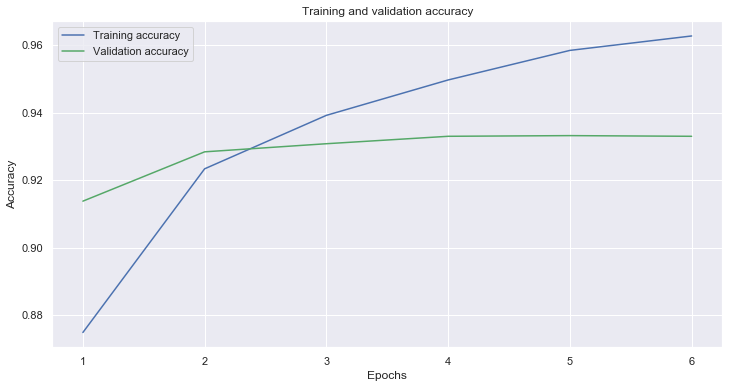

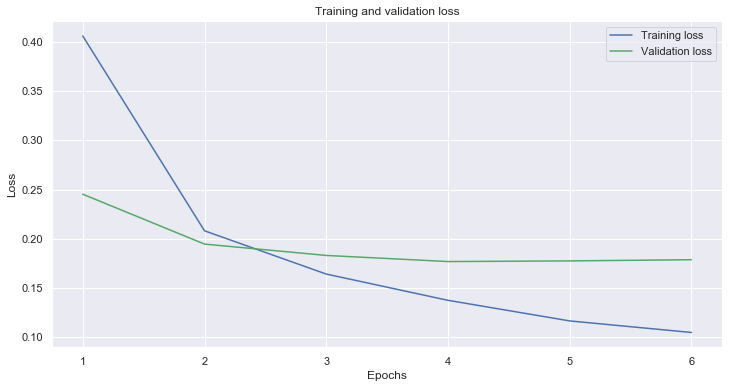

In [60]:
plot_history(history)